<a href="https://colab.research.google.com/github/LazaroR-u/EQNN/blob/main/EQNN_p4m_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
%%capture
pip install pennylane jax jaxlib

In [24]:
import pennylane as qml
import jax.numpy as jnp
import jax

## embedding

In [16]:
r"""Embedding classical image into quantum circuit"""

from typing import List


def embed_image(img: jnp.ndarray, wires: List[int]) -> None:
    r"""Embed classical image into quantum circuit in reflection and rotation equivariant way
    with Coordinate-Aware Amplitude Embedding.

    .. math::

        U(x)\ket{0} = \sum_i=1^n x_{i,j} \ket{i} \ket{j}

    Args:
        img (jnp.ndarray) : Image to embed into quantum circuit
        wires (List[int]) : Ordered list of quantum circuit wires to embed the image.
    """
    n = len(wires) // 2
    if img.shape[2] == 1:
        img = img.reshape(img.shape[0], img.shape[1])

    # Rewrite the images as amplitudes of the input quantum state
    features = jnp.zeros(2 ** (2 * n))

    for i in range(2**n):
        for j in range(2**n):
            features = features.at[2**n * i + j].set(
                jnp.sin(jnp.pi / 2 * (2 * img[i, j] - 1))
            )

    features = features / jnp.sqrt(jnp.sum(features**2))

    # Encode data with amplitude embedding
    qml.AmplitudeEmbedding(features, wires=wires)


In [90]:
matrix = [[1, 0, 1, 2], [0, -1, 3, 4], [ 0 , 1, 2, 3], [4, 5, 2, 0]]
matrix = jnp.array(matrix)
matrix = matrix.reshape(4,4,1)
matrix.shape

(4, 4, 1)

## ejemplo coordinate-aware amplitude embedding

(<Figure size 600x500 with 1 Axes>, <Axes: >)

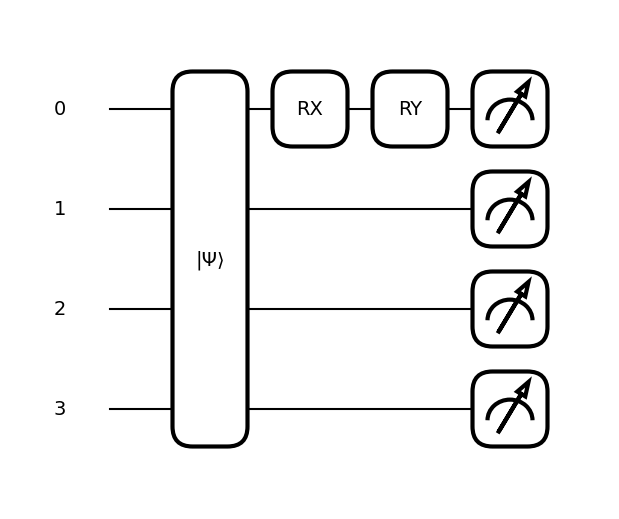

In [91]:
dev = qml.device("default.qubit", wires=3)

@qml.qnode(dev)
def circuit(params):
    embed_image(matrix, [0, 1,2,3])

    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    return qml.state()

qml.draw_mpl(circuit)(jnp.array([0.1, 0.2, 0.3]))

## unitary gates

In [17]:
r"""
This module contains the set of unitary circuit ansatz used to benchmark the performances of
non-equivariant Quantum Convolutional Neural Network (QCNN).

The QCNN ansatzs architecture are taken from the paper :
Hur, T., Kim, L. & Park, D.K. `Quantum convolutional neural network for classical data
classification <https://doi.org/10.1007/s42484-021-00061-xM>`__
"""

import pennylane as qml


class U_TTN(qml.operation.Operation):
    num_wires = 2
    num_params = 2  # Number of trainable parameters.

    ndim_params = tuple(0 for _ in range(num_params))

    grad_method = "A"  # Analytic Differentiation method to use.

    def __init__(self, *phi, wires, id=None):
        super().__init__(*phi, wires=wires, id=id)

    @staticmethod
    def compute_decomposition(*angle, wires):
        # Defines the decomposition of the new gate (called by Operator.decomposition())
        op_list = []

        op_list.append(qml.RY(angle[0], wires=wires[0]))
        op_list.append(qml.RY(angle[1], wires=wires[1]))
        op_list.append(qml.CNOT(wires=[wires[0], wires[1]]))

        return op_list


class U_6(qml.operation.Operation):
    num_wires = 2
    num_params = 10  # int: Number of trainable parameters that the operator depends on.

    ndim_params = tuple(0 for _ in range(num_params))

    grad_method = "A"  # Analytic Differentiation method to use.

    def __init__(self, *phi, wires, id=None):
        super().__init__(*phi, wires=wires, id=id)

    @staticmethod
    def compute_decomposition(*angle, wires):
        # Defines the decomposition of the new gate (called by Operator.decomposition())
        op_list = []

        op_list.append(qml.RX(angle[0], wires=wires[0]))
        op_list.append(qml.RX(angle[1], wires=wires[1]))
        op_list.append(qml.RZ(angle[2], wires=wires[0]))
        op_list.append(qml.RZ(angle[3], wires=wires[1]))
        op_list.append(qml.CRX(angle[4], wires=[wires[1], wires[0]]))
        op_list.append(qml.CRX(angle[5], wires=[wires[0], wires[1]]))
        op_list.append(qml.RX(angle[6], wires=wires[0]))
        op_list.append(qml.RX(angle[7], wires=wires[1]))
        op_list.append(qml.RZ(angle[8], wires=wires[0]))
        op_list.append(qml.RZ(angle[9], wires=wires[1]))


class U_SO4(qml.operation.Operation):
    num_wires = 2
    num_params = 6  # Number of trainable parameters.

    ndim_params = tuple(0 for _ in range(num_params))

    grad_method = "A"  # Analytic Differentiation method to use.

    def __init__(self, *phi, wires, id=None):
        super().__init__(*phi, wires=wires, id=id)

    @staticmethod
    def compute_decomposition(*angle, wires):
        # Defines the decomposition of the new gate (called by Operator.decomposition())
        op_list = []

        op_list.append(qml.RY(angle[0], wires=wires[0]))
        op_list.append(qml.RY(angle[1], wires=wires[1]))
        op_list.append(qml.CNOT(wires=[wires[0], wires[1]]))
        op_list.append(qml.RY(angle[2], wires=wires[0]))
        op_list.append(qml.RY(angle[3], wires=wires[1]))
        op_list.append(qml.CNOT(wires=[wires[0], wires[1]]))
        op_list.append(qml.RY(angle[4], wires=wires[0]))
        op_list.append(qml.RY(angle[5], wires=wires[1]))

        return op_list


class Pooling_ansatz(qml.operation.Operation):
    num_wires = 2
    num_params = 2  # Number of trainable parameters.

    ndim_params = tuple(0 for _ in range(num_params))

    grad_method = "A"  # Analytic Differentiation method to use.

    def __init__(self, *phi, wires, id=None):
        super().__init__(*phi, wires=wires, id=id)

    @staticmethod
    def compute_decomposition(*angle, wires):
        # Defines the decomposition of the new gate (called by Operator.decomposition())
        op_list = []

        op_list.append(qml.CRZ(angle[0], wires=[wires[1], wires[0]]))
        op_list.append(qml.PauliX(wires=wires[1]))
        op_list.append(qml.CRX(angle[1], wires=[wires[1], wires[0]]))

        return op_list


### example

[tensor(-0.54585942, requires_grad=True), tensor(-0.3540037, requires_grad=True), tensor(0.98990314, requires_grad=True), tensor(-1., requires_grad=True)]


(<Figure size 2200x500 with 1 Axes>, <Axes: >)

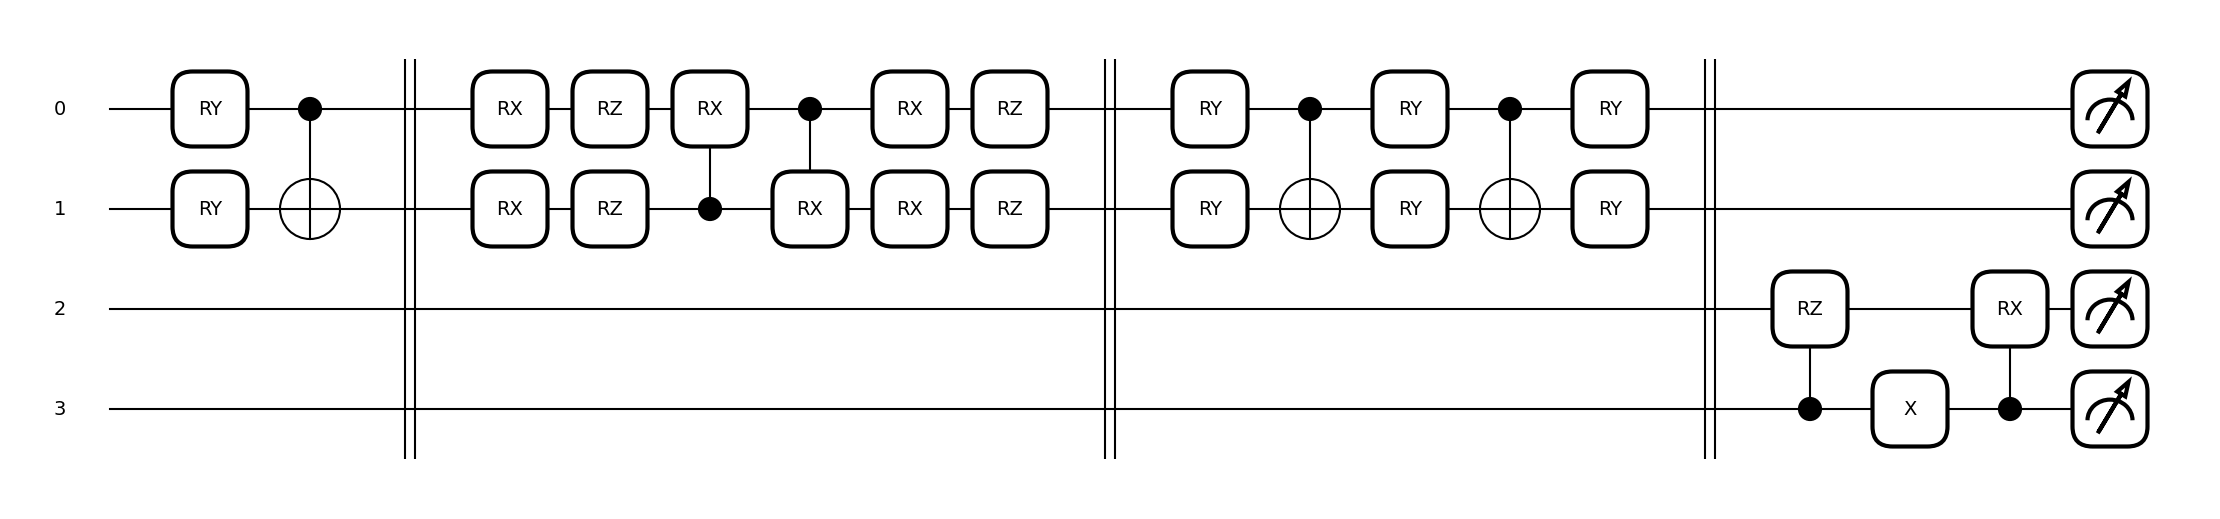

In [18]:
import pennylane as qml
from pennylane import numpy as np

def U_TTN(phi, wires):
    qml.RY(phi[0], wires=wires[0])
    qml.RY(phi[1], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])

def U_6(phi, wires):
    qml.RX(phi[0], wires=wires[0])
    qml.RX(phi[1], wires=wires[1])
    qml.RZ(phi[2], wires=wires[0])
    qml.RZ(phi[3], wires=wires[1])
    qml.CRX(phi[4], wires=[wires[1], wires[0]])
    qml.CRX(phi[5], wires=[wires[0], wires[1]])
    qml.RX(phi[6], wires=wires[0])
    qml.RX(phi[7], wires=wires[1])
    qml.RZ(phi[8], wires=wires[0])
    qml.RZ(phi[9], wires=wires[1])

def U_SO4(phi, wires):
    qml.RY(phi[0], wires=wires[0])
    qml.RY(phi[1], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(phi[2], wires=wires[0])
    qml.RY(phi[3], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(phi[4], wires=wires[0])
    qml.RY(phi[5], wires=wires[1])

def Pooling_ansatz(phi, wires):
    qml.CRZ(phi[0], wires=[wires[1], wires[0]])
    qml.PauliX(wires=wires[1])
    qml.CRX(phi[1], wires=[wires[1], wires[0]])

# Definir el dispositivo
dev = qml.device("default.qubit", wires=4)

@qml.qnode(dev)
def circuit(params):
    # Usar las funciones definidas
    U_TTN(params[:2], wires=[0, 1])
    qml.Barrier()
    U_6(params[2:12], wires=[0, 1])
    qml.Barrier()
    U_SO4(params[12:18], wires=[0, 1])
    qml.Barrier()
    Pooling_ansatz(params[18:], wires=[2, 3])

    # Medida
    return [qml.expval(qml.PauliZ(i)) for i in range(4)]

# Ejemplo de parámetros
params = np.random.random(20)

# Ejecutar el circuito
result = circuit(params)
print(result)
qml.draw_mpl(circuit)(params)

## Equiv unitary gates

In [19]:
def IsingZ4(phi : float) -> jnp.ndarray:
    """
    ZZZZ rotation. U(\phi) = (e^(i*phi*Z^\otimes4))

    Argument :
        phi (float) : Rotation angle

    Return :
        Diagonal matrix for IsingZ4 rotation
    """
    Z = jnp.array([[1, 0], [0, -1]])
    Z4 = jnp.kron(Z, jnp.kron(Z, jnp.kron(Z, Z)))

    Z4_diag = jnp.diag(jnp.exp(1j*phi*Z4))

    return Z4_diag

class equiv_U2(qml.operation.Operation):
    num_wires = 2
    num_params = 6 # Number of trainable parameters.

    ndim_params = tuple(0 for _ in range(num_params))

    grad_method = "A" # Analytic Differentiation method to use.

    def __init__(self, *phi, wires, id=None):
        super().__init__(*phi, wires=wires, id=id)

    @staticmethod
    def compute_decomposition(*angle, wires):
        # Defines the decomposition of the new gate (called by Operator.decomposition())
        op_list = []

        op_list.append(qml.RX(angle[0], wires = wires[0]))
        op_list.append(qml.RX(angle[1], wires = wires[1]))
        op_list.append(qml.IsingZZ(angle[2], wires = wires))
        op_list.append(qml.RX(angle[3], wires = wires[0]))
        op_list.append(qml.RX(angle[4], wires = wires[1]))
        op_list.append(qml.IsingYY(angle[5], wires = wires))

        return op_list


class equiv_U4(qml.operation.Operation):
    num_wires = 4
    num_params = 3 # Number of trainable parameters.

    ndim_params = tuple(0 for _ in range(num_params))


    grad_method = "A" # Analytic Differentiation method to use.

    def __init__(self, *phi, wires, id=None):
        super().__init__(*phi, wires=wires, id=id)

    @staticmethod
    def compute_decomposition(*angle, wires):
        # Defines the decomposition of the new gate (called by Operator.decomposition())
        op_list = []

        op_list.append(qml.RX(angle[0], wires = wires[0]))
        op_list.append(qml.RX(angle[1], wires = wires[1]))
        op_list.append(qml.RX(angle[0], wires = wires[2]))
        op_list.append(qml.RX(angle[1], wires = wires[3]))
        op_list.append(qml.DiagonalQubitUnitary(IsingZ4(angle[2]), wires = wires))

        return op_list


class Pooling_ansatz(qml.operation.Operation):
    num_wires = 2
    num_params = 5 # Number of trainable parameters.

    ndim_params = tuple(0 for _ in range(num_params))

    grad_method = "A" # Analytic Differentiation method to use.

    def __init__(self, *phi, wires, id=None):
        super().__init__(*phi, wires=wires, id=id)

    @staticmethod
    def compute_decomposition(*angle, wires):
        # Defines the decomposition of the new gate (called by Operator.decomposition())
        op_list = []

        op_list.append(qml.RX(angle[0], wires = wires[0]))
        op_list.append(qml.RX(angle[1], wires = wires[1]))
        op_list.append(qml.RY(angle[2], wires = wires[1]))
        op_list.append(qml.RZ(angle[3], wires = wires[1]))
        op_list.append(qml.CRX(angle[4], wires = [wires[1], wires[0]]))
        return op_list


## example

## QCNN

### No - Equivariant

In [20]:

class QCNN() :
    r"""Quantum Convolutional Neural Network constructed with the specified architecture.

    Args:
        num_qubits (int): Number of qubits in the QCNN.
        num_measured (int): Number of qubits to be measured at the end of the circuit.
            For :math:`L` class classification, we measure ``ceil(log2(num_classes))`` qubits.
        trans_inv (bool)" Boolean to indicate whether the model is constructed in a translational invariant way,
            i.e., whether all the filters in each layer share the same parameters. (To be implemented).

    Keyword Args:
        qnn_ver (str): Name of the QNN architecture predefined in .


    Example:

        >>> qcnn = QCNN(num_qubits = 4, num_measured = 1, qnn_ver = "U_TTN")
        >>> qcnn = QCNN(num_qubits = 4, num_measured = 1, conv_filters = "U_TTN",
        ...         pooling = "Poolin_ansatz1")
    """

    _valid_gates = {
        "RZ" : qml.RZ,
        "U_TTN" : U_TTN,
        "U_SO4" : U_SO4,
        "Pooling_ansatz" : Pooling_ansatz
    }

    #_qnn_config_path = os.path.join(os.path.dirname(__file__), "qnn_architecture.json")


    def __init__(self,
                 num_qubits: int,
                 num_measured: int,
                 trans_inv: bool = True,
                 **kwargs
                ) -> None :

        qnn_architecture = {'conv_filters' : ['U_TTN'],
                            'pooling' : 'Pooling_ansatz1'}
        if "qnn_ver" in kwargs.keys() :
            qnn_architecture = json.load(open(self._qnn_config_path))[kwargs['qnn_ver']]
        else :
            for k in kwargs.keys() :
                qnn_architecture[k] = kwargs[k]

        self._qnn_architecture = qnn_architecture
        self._num_qubits = num_qubits
        self._num_measured = num_measured

        self._rotation_gates = []
        if 'conv_filters' in qnn_architecture.keys() :
            self._conv_filters = [self._choose_gate(gate) for gate in qnn_architecture['conv_filters']]

        self._pooling = []
        if 'pooling' in qnn_architecture.keys() :
            self._pooling = self._choose_gate(qnn_architecture['pooling'])

        depth = ceil(np.log2(num_qubits//num_measured))
        self._meas_wires = [i for i in range(num_qubits//2)]
        while len(self._meas_wires) > num_measured:
            self._meas_wires = [self._meas_wires[i] for i in range(0, len(self._meas_wires), 2)]


        self._meas_wires = np.array(self._meas_wires)

        self._num_params = depth*(sum([gate[2] for gate in self._conv_filters]) + self._pooling[2])



    @staticmethod
    def _choose_gate(gate_str : str) -> Tuple[str, qml.operation.Operation, int, int] :
        gate = QCNN._valid_gates.get(gate_str, None)

        if gate is None :
            raise NotImplementedError("Unknown gate.")

        return (gate_str, gate, gate.num_params, gate.num_wires)


    def _get_circuit(self,
                     num_qubits: int,
                     num_measured : int,
                     conv_filters,
                     pooling) :

        def circuit(params) :
            idx = 0

            wires = np.array([i for i in range(num_qubits)])

            while len(wires) > num_measured :
                for _, gate, num_params, gate_num_wires in conv_filters :
                    for i in range(0, len(wires), 2) :
                        gate(*params[idx : idx + num_params], wires = [wires[i], wires[i+1]])
                    for i in range(1, len(wires)-1, 2) :
                        gate(*params[idx : idx + num_params], wires = [wires[i], wires[i+1]])

                    gate(*params[idx : idx + num_params], wires = [wires[-1], wires[0]])

                    idx = idx + num_params

                _, gate, num_params, gate_num_wires = pooling

                traced_out_wires = []

                if len(wires) > 2 :
                    for i in range(0, len(wires)//2 -1, 2) :
                        gate(*params[idx : idx + num_params], wires = [wires[i], wires[i+1]])
                        traced_out_wires.append(i+1)


                    for i in range(len(wires)//2, len(wires) -1, 2) :
                        gate(*params[idx : idx + num_params], wires = [wires[i], wires[i+1]])
                        traced_out_wires.append(i+1)
                else :
                    for i in range(0, len(wires), 2) :
                        gate(*params[idx : idx + num_params], wires = [wires[i], wires[i+1]])
                        traced_out_wires.append(i+1)

                idx = idx + num_params

                wires = np.delete(wires, traced_out_wires)


        return circuit

    def get_circuit(self) -> Tuple[Callable, List[int]]:
        r"""Function to return quantum circuit constructed with the architecture specified for
        the QCNN instance.

        Returns:
            Tuple[Callable, List[int]]: Tuple of a Callable representing the quantum circuit
            and a list of integers corresponding to the qubits to be measured at the end of
            the circuit.
        """
        return self._get_circuit(self._num_qubits, self._num_measured, self._conv_filters,
                                 self._pooling), self._meas_wires

    def __str__(self) :
        disp = f"Quantum Convolutional Neural Network with architecture :\n"
        disp += f"  - Convolutional filters : {[gate[0] for gate in self._conv_filters]}\n"
        disp += f"  - Pooling : {self._pooling[0]}\n"

        return disp


### Equivariant

In [21]:
import sys
import os
#sys.path.append(os.path.dirname(__file__))

import json

import jax.numpy as jnp

import numpy as np
import pennylane as qml
#import unitary
#import equiv_unitary
from math import ceil

from typing import Tuple, Callable, List


class EquivQCNN() :
    _valid_gates = {
        "U2" : equiv_U2,
        "U4" : equiv_U4,
        "equiv_Pooling_ansatz" : Pooling_ansatz,
    }
    _valid_gates.update(QCNN._valid_gates)

    _#qnn_config_path = os.path.join(os.path.dirname(__file__), "equiv_qnn_architecture.json")


    def __init__(self,
                 num_qubits: int,
                 num_measured: int,
                 trans_inv: bool,
                 **kwargs
                ) :

        qnn_architecture = {'U2_conv_filters' : ['U2_ver1'],
                            'U4_conv_filters' : ['U4_ver1'],
                            'pooling' : 'equiv_Pooling_ansatz1',
                             'alternating' : False}
        if "qnn_ver" in kwargs.keys() :
            qnn_architecture = json.load(open(self._qnn_config_path))[kwargs['qnn_ver']]
        else :
            for k in kwargs.keys() :
                qnn_architecture[k] = kwargs[k]

        print(kwargs.keys())

        if "sym_break" in kwargs.keys() :
            self._sym_break = kwargs['sym_break']
        else :
            self._sym_break = False

        self._qnn_architecture = qnn_architecture
        self._num_qubits = num_qubits
        self._num_measured = num_measured
        self._trans_inv = trans_inv

        self._rotation_gates = []
        if 'U2_conv_filters' in qnn_architecture.keys() :
            self._U2_conv_filters = [self._choose_gate(gate) for gate in qnn_architecture['U2_conv_filters']]

        if 'U4_conv_filters' in qnn_architecture.keys() :
            self._U4_conv_filters = [self._choose_gate(gate) for gate in qnn_architecture['U4_conv_filters']]

        self._pooling = []
        if 'pooling' in qnn_architecture.keys() :
            self._pooling = self._choose_gate(qnn_architecture['pooling'])

        self._noisy_filters = []
        if 'noisy_filters' in qnn_architecture.keys() :
            self._noisy_filters = [self._choose_gate(gate) for gate in qnn_architecture['noisy_filters']]


        if 'alternating' in qnn_architecture.keys() :
            self._alternating = qnn_architecture['alternating']

        depth = ceil(np.log2(num_qubits//num_measured))

        self._meas_wires = [i for i in range(num_qubits//2)]
        while len(self._meas_wires) > num_measured/2 :
            self._meas_wires = [self._meas_wires[i] for i in range(0, len(self._meas_wires), 2)]

        self._meas_wires.extend([q + num_qubits//2 for q in self._meas_wires])
        self._meas_wires = np.array(self._meas_wires)

        num_gates = 1
        if not trans_inv :
            num_gates = num_qubits//2

        if not self._alternating :
            self._num_params = num_gates*(sum([gate[2] for gate in self._U2_conv_filters]) + \
                                        depth*(sum([gate[2] for gate in self._U4_conv_filters]) + \
                                               sum([gate[2] for gate in self._noisy_filters]) + \
                                               self._pooling[2]))
        else :
            self._num_params = num_gates*depth*(sum([gate[2] for gate in self._U2_conv_filters]) + \
                                      sum([gate[2] for gate in self._U4_conv_filters]) + \
                                                sum([gate[2] for gate in self._noisy_filters]) + \
                                                self._pooling[2])


#         Symmetry breaking
        if self._sym_break:
            self._num_params += 1

    @staticmethod
    def _choose_gate(gate_str : str) :
        gate = EquivQCNN._valid_gates.get(gate_str, None)

        if gate is None :
            raise NotImplementedError("Unknown gate.")

        return (gate_str, gate, gate.num_params, gate.num_wires)


    def _U2_conv(self, params, gate, wires) :
        idx  = 0
        for i in range(0, len(wires), 2) :
            gate(*params[idx], wires = [wires[i], wires[i+1]])
            idx = idx + 1

        for i in range(1, len(wires)-1, 2) :
            gate(*params[idx], wires = [wires[i], wires[i+1]])
            idx = idx + 1

        gate(*params[idx], wires = [wires[-1], wires[0]])


    def _U4_conv(self, params, gate, wires) :
        idx = 0
        for i in range(0, len(wires), 4):
            gate(*params[idx], wires = [wires[i + j] for j in range(4)])
            idx = idx + 1

        for i in range(2, len(wires)-2, 4):
            gate(*params[idx], wires = [wires[i + j] for j in range(4)])
            idx = idx + 1

        if len(wires) > 4 :
            gate(*params[idx], wires = [wires[0], wires[1], wires[-2], wires[-1]])


    def _get_circuit(self, num_qubits, num_measured, U2_conv_filters, U4_conv_filters, pooling, noisy_filters, alternating, trans_inv, sym_break) :

        def circuit(params) :
            idx = 0

            wires = np.array([i for i in range(num_qubits)])

            if not alternating :
                for _, gate, num_params, gate_num_wires in U2_conv_filters :
                    num_gates = len(wires)//2

                    if trans_inv :
                        conv_params = jnp.repeat(jnp.array([params[idx : idx + num_params]]), num_gates, axis = 0)
                        num_gates = 1
                    else :

                        conv_params = params[idx : idx + num_gates*num_params].reshape((num_gates, num_params))

                    self._U2_conv(conv_params, gate, wires[:len(wires)//2])
                    self._U2_conv(conv_params, gate, wires[len(wires)//2:])

                    idx = idx + num_gates*num_params

            while len(wires) > num_measured :
                if alternating :
                    for _, gate, num_params, gate_num_wires in U2_conv_filters :
                        num_gates = len(wires)//2

                        if trans_inv :
                            conv_params = jnp.repeat(jnp.array([params[idx : idx + num_params]]), num_gates, axis = 0)
                            num_gates = 1
                        else :
                            conv_params = params[idx : idx + num_gates*num_params].reshape((num_gates, num_params))

                        self._U2_conv(conv_params, gate, wires[:len(wires)//2])
                        self._U2_conv(conv_params, gate, wires[len(wires)//2:])

                        idx = idx + num_gates*num_params

                for _, gate, num_params, gate_num_wires in U4_conv_filters :
                    num_gates = len(wires)//2

                    if trans_inv :
                        conv_params = jnp.repeat(jnp.array([params[idx : idx + num_params]]), num_gates, axis = 0)
                        num_gates = 1
                    else :
                        conv_params = params[idx : idx + num_gates*num_params].reshape((num_gates, num_params))

                    self._U4_conv(conv_params, gate, wires)

                    idx = idx + num_gates*num_params


                for _, gate, num_params, gate_num_wires in noisy_filters :
                    num_gates = len(wires)

                    if trans_inv :
                        conv_params = jnp.repeat(jnp.array([params[idx : idx + num_params]]), num_gates, axis = 0)
                        num_gates = 1
                    else :
                        conv_params = params[idx : idx + num_gates*num_params].reshape((num_gates, num_params))

                    self._U2_conv(conv_params, gate, wires)

                    idx = idx + num_gates*num_params


                _, gate, num_params, gate_num_wires = pooling
                num_gates = len(wires)//4
                if trans_inv :
                    conv_params = jnp.repeat(jnp.array([params[idx : idx + num_params]]), num_gates, axis = 0)
                    num_gates = 1

                else :
                    conv_params = params[idx : idx + num_gates*num_params].reshape((num_gates, num_params))

                traced_out_wires = []
                for i in range(0, len(wires)//2 -1, 2) :
                    gate(*conv_params[i//2], wires = [wires[i], wires[i+1]])
                    traced_out_wires.append(i+1)
                for i in range(len(wires)//2, len(wires) -1, 2) :
                    gate(*conv_params[(i-len(wires)//2)//2], wires = [wires[i], wires[i+1]])
                    traced_out_wires.append(i+1)

                idx = idx + num_params*num_gates



                wires = np.delete(wires, traced_out_wires)
            if sym_break:
                for i in wires :
                    qml.RZ(params[-1], wires = i)
        return circuit

    def get_circuit(self) :

        return self._get_circuit(self._num_qubits, self._num_measured, self._U2_conv_filters, self._U4_conv_filters,
                                 self._pooling, self._noisy_filters, self._alternating, self._trans_inv, self._sym_break), self._meas_wires

    def __str__(self) :
        disp = f"Quantum Convolutional Neural Network with architecture :\n"
        disp += f"  - Convolutional filters : {[gate[0] for gate in self._conv_filters]}\n"
        disp += f"  - Pooling : {self._pooling[0]}\n"

        return disp



### ejemplo de EQNN usando la clase

/usr/local/lib/python3.10/dist-packages/pennylane/math/utils.py:227: UserWarning: Contains tensors of types {'jax', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


(Array([0.30963182, 0.24431205, 0.244312  , 0.20174254], dtype=float32), Array([0.3096319 , 0.24431202, 0.24431199, 0.20174257], dtype=float32))


(<Figure size 3100x900 with 1 Axes>, <Axes: >)

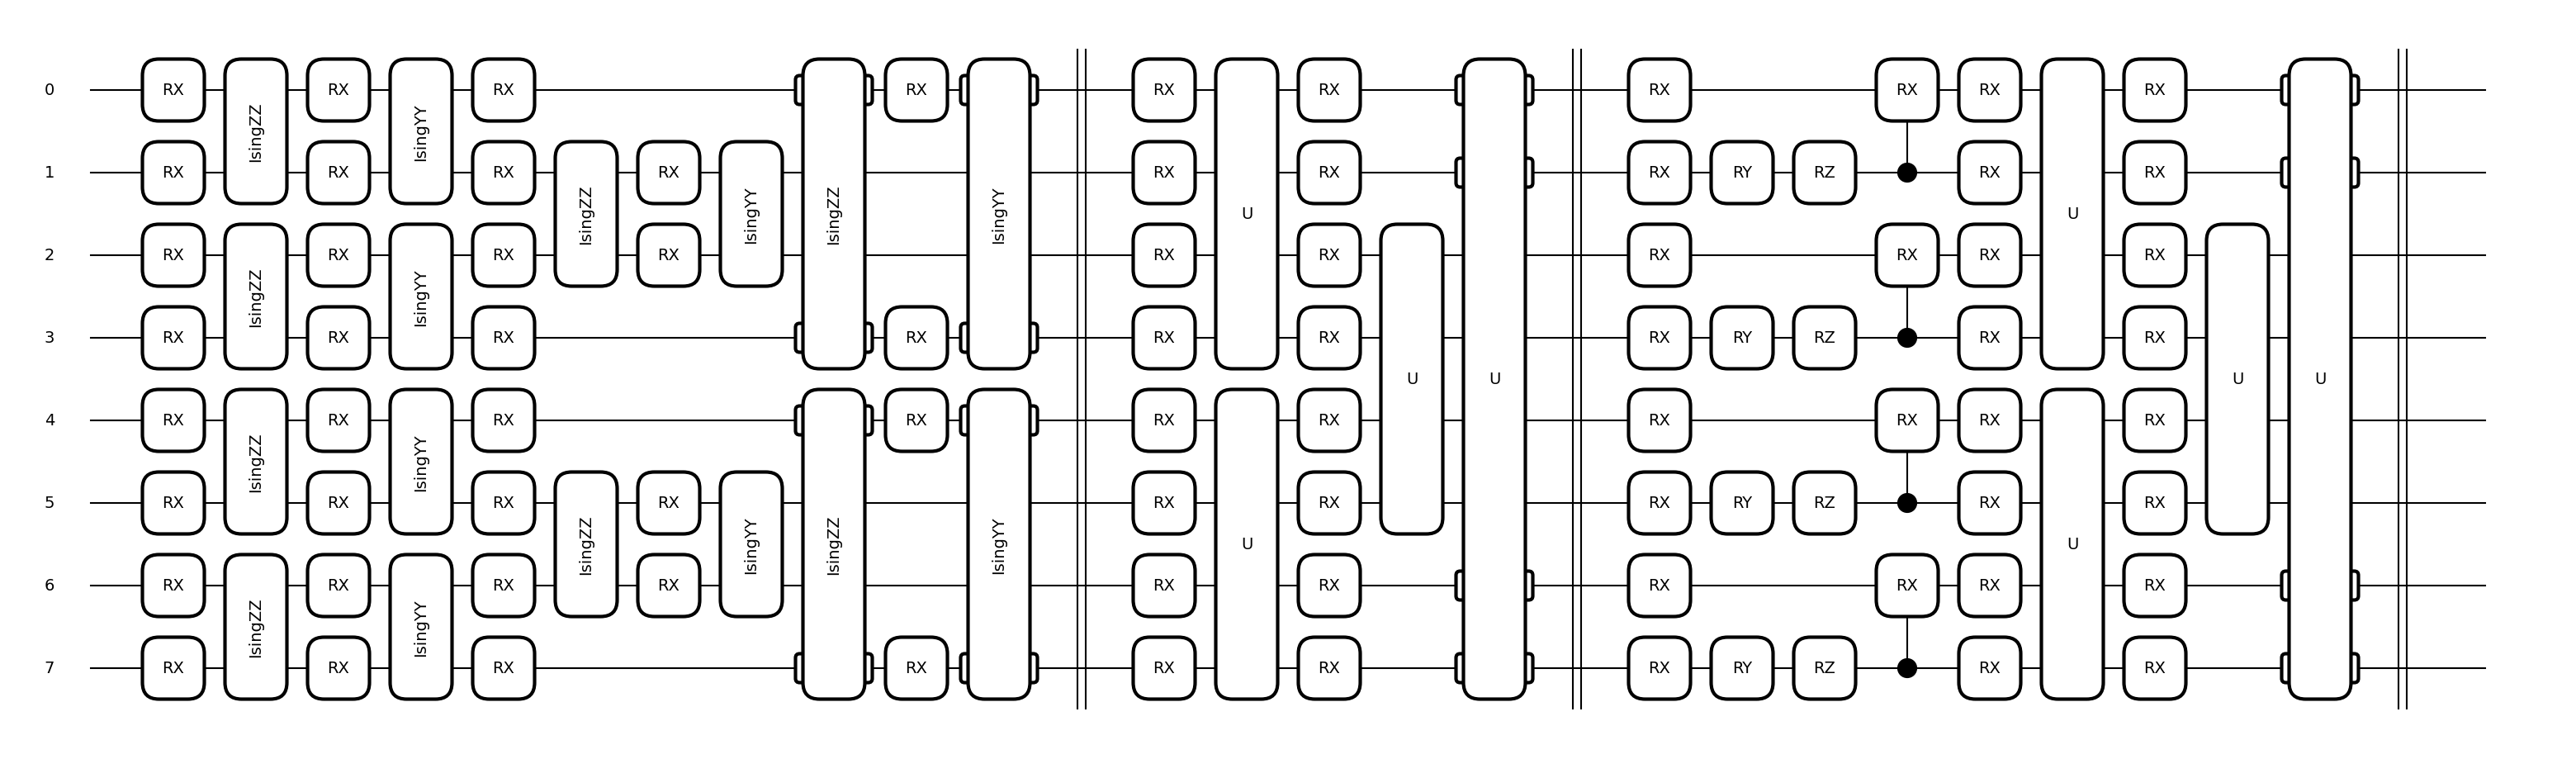

In [101]:
import json
import jax.numpy as jnp
import numpy as np
import pennylane as qml
from math import ceil

# Definir las funciones para las puertas cuánticas

def U2(phi, wires):
    qml.RX(phi[0], wires=wires[0])
    qml.RX(phi[1], wires=wires[1])
    qml.IsingZZ(phi[2], wires=wires)
    qml.RX(phi[3], wires=wires[0])
    qml.RX(phi[4], wires=wires[1])
    qml.IsingYY(phi[5], wires=wires)

def U4(phi, wires):
    qml.RX(phi[0], wires=wires[0])
    qml.RX(phi[1], wires=wires[1])
    qml.RX(phi[0], wires=wires[2])
    qml.RX(phi[1], wires=wires[3])
    Z = np.array([[1, 0], [0, -1]])
    Z4 = np.kron(Z, np.kron(Z, np.kron(Z, Z)))
    Z4_diag = np.diag(np.exp(1j * phi[2] * Z4))
    qml.DiagonalQubitUnitary(Z4_diag, wires=wires)

def Pooling_ansatz(phi, wires):
    qml.RX(phi[0], wires=wires[0])
    qml.RX(phi[1], wires=wires[1])
    qml.RY(phi[2], wires=wires[1])
    qml.RZ(phi[3], wires=wires[1])
    qml.CRX(phi[4], wires=[wires[1], wires[0]])

# Configuración inicial

class EquivQCNN:
    def __init__(self, num_qubits, num_measured, trans_inv, **kwargs):
        qnn_architecture = {
            'U2_conv_filters': [U2],
            'U4_conv_filters': [U4],
            'pooling': Pooling_ansatz,
            'alternating': False
        }

        self._sym_break = kwargs.get('sym_break', False)
        self._qnn_architecture = qnn_architecture
        self._num_qubits = num_qubits
        self._num_measured = num_measured
        self._trans_inv = trans_inv

        self._U2_conv_filters = qnn_architecture['U2_conv_filters']
        self._U4_conv_filters = qnn_architecture['U4_conv_filters']
        self._pooling = qnn_architecture['pooling']
        self._alternating = qnn_architecture['alternating']

        depth = ceil(np.log2(num_qubits // num_measured))

        self._meas_wires = [i for i in range(num_qubits // 2)]
        while len(self._meas_wires) > num_measured // 2:
            self._meas_wires = [self._meas_wires[i] for i in range(0, len(self._meas_wires), 2)]

        self._meas_wires.extend([q + num_qubits // 2 for q in self._meas_wires])
        self._meas_wires = np.array(self._meas_wires)

        num_gates = 1
        if not trans_inv:
            num_gates = num_qubits // 2

        if not self._alternating:
            self._num_params = num_gates * (sum([6 for _ in self._U2_conv_filters]) +
                                            depth * (sum([3 for _ in self._U4_conv_filters]) +
                                                     5))
        else:
            self._num_params = num_gates * depth * (sum([6 for _ in self._U2_conv_filters]) +
                                                    sum([3 for _ in self._U4_conv_filters]) +
                                                    5)

        if self._sym_break:
            self._num_params += 1

    def _U2_conv(self, params, gate, wires):
        idx = 0
        for i in range(0, len(wires), 2):
            gate(params[idx], wires=[wires[i], wires[i + 1]])
            idx += 1

        for i in range(1, len(wires) - 1, 2):
            gate(params[idx], wires=[wires[i], wires[i + 1]])
            idx += 1

        gate(params[idx], wires=[wires[-1], wires[0]])

    def _U4_conv(self, params, gate, wires):
        idx = 0
        for i in range(0, len(wires), 4):
            gate(params[idx], wires=[wires[i + j] for j in range(4)])
            idx += 1

        for i in range(2, len(wires) - 2, 4):
            gate(params[idx], wires=[wires[i + j] for j in range(4)])
            idx += 1

        if len(wires) > 4:
            gate(params[idx], wires=[wires[0], wires[1], wires[-2], wires[-1]])

    def _get_circuit(self, num_qubits, num_measured, U2_conv_filters, U4_conv_filters, pooling, alternating, trans_inv, sym_break):
        def circuit(params):
            idx = 0
            wires = np.array([i for i in range(num_qubits)])

            if not alternating:
              ### U2
                for gate in U2_conv_filters:
                    num_gates = len(wires) // 2
                    if trans_inv:
                        conv_params = jnp.repeat(jnp.array([params[idx: idx + 6]]), num_gates, axis=0)
                        num_gates = 1
                    else:
                        conv_params = params[idx: idx + num_gates * 6].reshape((num_gates, 6))

                    self._U2_conv(conv_params, gate, wires[:len(wires) // 2])
                    self._U2_conv(conv_params, gate, wires[len(wires) // 2:])
                    idx += num_gates * 6
                    qml.Barrier()

            ### U4
            while len(wires) > num_measured:
                if alternating:
                    for gate in U2_conv_filters:
                        num_gates = len(wires) // 2
                        if trans_inv:
                            conv_params = jnp.repeat(jnp.array([params[idx: idx + 6]]), num_gates, axis=0)
                            num_gates = 1

                        else:
                            conv_params = params[idx: idx + num_gates * 6].reshape((num_gates, 6))

                        self._U2_conv(conv_params, gate, wires[:len(wires) // 2])
                        self._U2_conv(conv_params, gate, wires[len(wires) // 2:])
                        idx += num_gates * 6
                        qml.Barrier()
                for gate in U4_conv_filters:
                    num_gates = len(wires) // 2
                    if trans_inv:
                        conv_params = jnp.repeat(jnp.array([params[idx: idx + 3]]), num_gates, axis=0)
                        num_gates = 1
                    else:
                        conv_params = params[idx: idx + num_gates * 3].reshape((num_gates, 3))

                    self._U4_conv(conv_params, gate, wires)
                    idx += num_gates * 3
                    qml.Barrier()
                conv_params = jnp.repeat(jnp.array([params[idx: idx + 5]]), len(wires) // 4, axis=0)
                idx += 5

                traced_out_wires = []
                for i in range(0, len(wires) // 2 - 1, 2):
                    pooling(conv_params[i // 2], wires=[wires[i], wires[i + 1]])
                    traced_out_wires.append(i + 1)

                for i in range(len(wires) // 2, len(wires) - 1, 2):
                    pooling(conv_params[(i - len(wires) // 2) // 2], wires=[wires[i], wires[i + 1]])
                    traced_out_wires.append(i + 1)


                for gate in U4_conv_filters:
                    num_gates = len(wires) // 2
                    if trans_inv:
                        conv_params = jnp.repeat(jnp.array([params[idx: idx + 3]]), num_gates, axis=0)
                        num_gates = 1
                    else:
                        conv_params = params[idx: idx + num_gates * 3].reshape((num_gates, 3))

                    self._U4_conv(conv_params, gate, wires)
                    idx += num_gates * 3
                    qml.Barrier()
                conv_params = jnp.repeat(jnp.array([params[idx: idx + 5]]), len(wires) // 4, axis=0)
                idx += 5

                wires = np.delete(wires, traced_out_wires)



            if sym_break:
                for i in wires:
                    qml.RZ(params[-1], wires=i)

        return circuit

    def get_circuit(self):
        return self._get_circuit(self._num_qubits, self._num_measured, self._U2_conv_filters, self._U4_conv_filters,
                                 self._pooling, self._alternating, self._trans_inv, self._sym_break), self._meas_wires

# Configuración del dispositivo y parámetros

num_qubits = 8
num_measured = 4
trans_inv = True
params = np.random.random(64)

model = EquivQCNN(num_qubits, num_measured, trans_inv)
circuit, meas_wires = model.get_circuit()

# Definir el QNode
dev = qml.device("default.qubit", wires=num_qubits)

@qml.qnode(dev)
def qcnn(params):
    circuit(params)
    return qml.probs(wires = meas_wires[:len(meas_wires)//2]), qml.probs(wires = meas_wires[len(meas_wires)//2:])

# Ejecutar el circuito
results = qcnn(params)
print(results)
qml.draw_mpl(circuit)(params)

# EQNN casero

[Array(0.15402794, dtype=float32), Array(-0.08246899, dtype=float32)]


(<Figure size 3300x900 with 1 Axes>, <Axes: >)

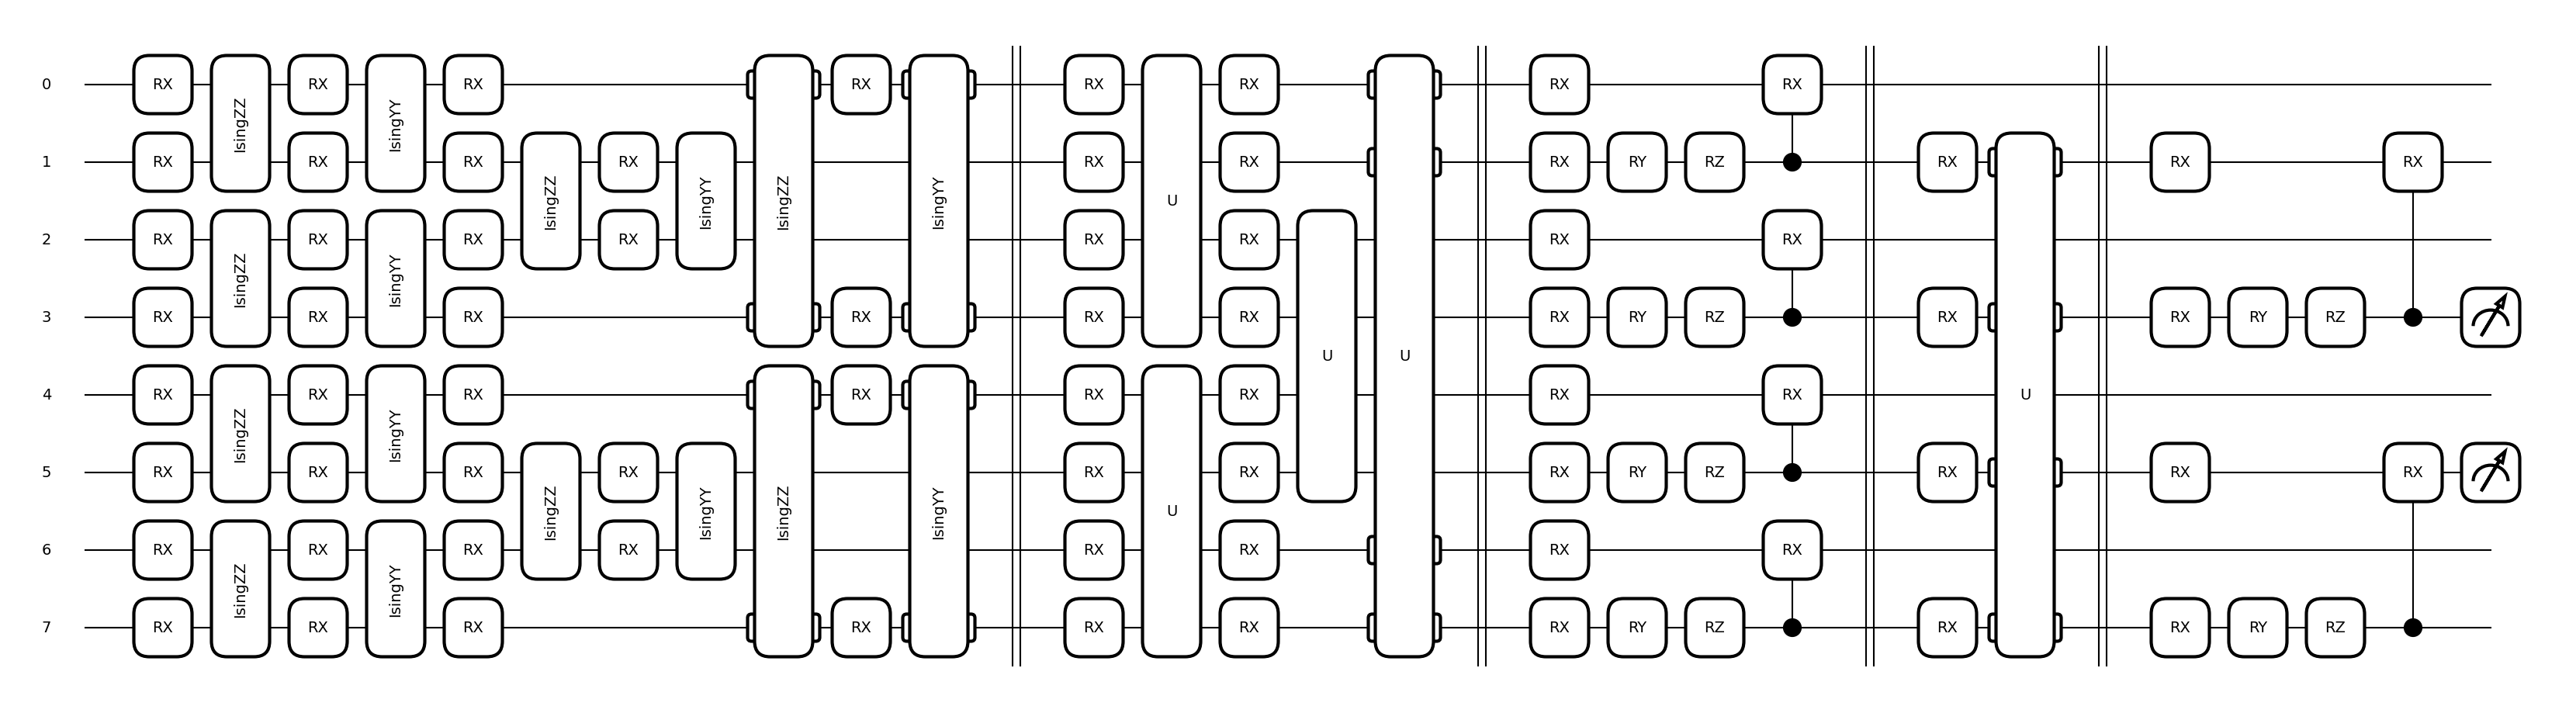

In [107]:

def U2(phi, wires):
    qml.RX(phi[0], wires=wires[0])
    qml.RX(phi[1], wires=wires[1])
    qml.IsingZZ(phi[2], wires=wires)
    qml.RX(phi[3], wires=wires[0])
    qml.RX(phi[4], wires=wires[1])
    qml.IsingYY(phi[5], wires=wires)

def U4(phi, wires):
    qml.RX(phi[0], wires=wires[0])
    qml.RX(phi[1], wires=wires[1])
    qml.RX(phi[0], wires=wires[2])
    qml.RX(phi[1], wires=wires[3])
    Z = np.array([[1, 0], [0, -1]])
    Z4 = np.kron(Z, np.kron(Z, np.kron(Z, Z)))
    Z4_diag = np.diag(np.exp(1j * phi[2] * Z4))
    qml.DiagonalQubitUnitary(Z4_diag, wires=wires)

def Pooling_ansatz(phi, wires):
    qml.RX(phi[0], wires=wires[0])
    qml.RX(phi[1], wires=wires[1])
    qml.RY(phi[2], wires=wires[1])
    qml.RZ(phi[3], wires=wires[1])
    qml.CRX(phi[4], wires=[wires[1], wires[0]])



#########

def qcnn_full(params, wires):
  ## U2. 6 params per gate
    for i in range(int(len(wires)/2)):
      U2(params[4*i:i*4+6], [wires[2*i], wires[2*i+1]]) # Changed indexing to a list
    U2(params[24:30], [wires[1], wires[2]]) # Changed indexing to a list
    U2(params[30:36], [wires[5], wires[6]]) # Changed indexing to a list
    U2(params[36:42], [wires[0], wires[3]]) # Changed indexing to a list
    U2(params[42:48], [wires[4], wires[7]]) # Changed indexing to a list
    qml.Barrier()
  ## U4. 3 params per gate
    U4(params[48:51], wires[0:4]) # Changed indexing to a slice
    U4(params[51:54], wires[4:8]) # Changed indexing to a slice
    U4(params[54:57], wires[2:6]) # Changed indexing to a slice
    U4(params[57:60], [wires[0], wires[1], wires[6], wires[7]])
    qml.Barrier()
  ## POOLING. 5 params per gate
    for i in range(int(len(wires)/2)):
      Pooling_ansatz(params[60+i*5:60+i*5+5], [wires[2*i], wires[2*i+1]]) # Changed indexing to a list
    qml.Barrier()

  ## U4. 3 params
    U4(params[80:83], [wires[1], wires[3], wires[5], wires[7]])
    qml.Barrier()

  ## POOLING. 5 params
    Pooling_ansatz(params[83:88], [wires[1], wires[3]])
    Pooling_ansatz(params[88:93], [wires[5], wires[7]])


num_qubits = 8
num_measured = 4
#trans_inv = True
params = np.random.random(93)

#model = EquivQCNN(num_qubits, num_measured, trans_inv)
#circuit, meas_wires = model.get_circuit()

# Definir el QNode
dev = qml.device("default.qubit", wires=num_qubits)

@qml.qnode(dev, interface="jax")
def qcnn(params):
    qcnn_full(params, [0,1,2,3,4,5,6,7])
    return [qml.expval(qml.PauliZ(3)), qml.expval(qml.PauliZ(5))]

# Ejecutar el circuito
results = qcnn(params)
print(results)
qml.draw_mpl(qcnn)(params)

(<Figure size 400x100 with 1 Axes>, <Axes: >)

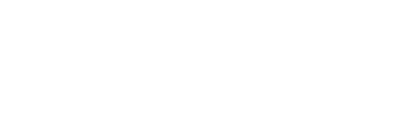

In [120]:
# tuvimos que cambiar la compuerta U4 para que usara objetos de jnp en lugar de np.
# En este circuito se intenta utilizar la EQNN completa, desde el embedding, el equivariant ansatz hasta la medicion
# sin embargo, el output es un objeto jnp con numeros complejos, aun se desconoce la razon de esto.


def U4(phi, wires):
    qml.RX(phi[0], wires=wires[0])
    qml.RX(phi[1], wires=wires[1])
    qml.RX(phi[0], wires=wires[2])
    qml.RX(phi[1], wires=wires[3])
    Z = jnp.array([[1, 0], [0, -1]]) # Use jnp.array instead of np.array
    Z4 = jnp.kron(Z, jnp.kron(Z, jnp.kron(Z, Z))) # Use jnp.kron instead of np.kron
    Z4_diag = jnp.diag(jnp.exp(1j * phi[2] * Z4)) # Use jnp.diag and jnp.exp
    qml.DiagonalQubitUnitary(Z4_diag, wires=wires)


params = np.random.random(93)

# Generar una matriz 16x16x1 con entradas entre 0 y 1
matrix = np.random.rand(16, 16, 1)
matrix = jnp.array(matrix)


num_qubits = 8

# Definir el QNode
dev = qml.device("default.qubit", wires=num_qubits)

@jax.jit
@qml.qnode(dev, interface = "jax")
def circuit(X, params) :

  embed_image(X, [0,1,2,3,4,5,6,7])
#  model = EquivQCNN(num_qubits, num_measured, trans_inv)
#  qcnn_circuit, meas_wires = model.get_circuit()
  qcnn_full(params, [0,1,2,3,4,5,6,7])
  qml.Hadamard(3)
  qml.Hadamard(7)
  #return qml.probs(wires = meas_wires[:len(meas_wires)//2]), qml.probs(wires = meas_wires[len(meas_wires)//2:])
  return [qml.expval(qml.PauliZ(3)), qml.expval(qml.PauliZ(5))]

# Ejecutar el circuito

qml.draw_mpl(circuit)(matrix, params)

In [ ]:
# esta parte ya esta contenida en el bloque anterior, solamente se define el quantum classifier juntando todos los elementos:
# el embedding, el ansatz y las mediciones.

r"""
Construct the quantum circuit for the quantum classifier
"""

import os
import sys
#sys.path.append(os.path.dirname(__file__))

import numpy as np

import jax
import pennylane as qml

from typing import Tuple, Callable, Optional

#from qcnn import *
#from data_embedding import *

def get_quantum_circuit(num_qubits : int,
                         num_measured : int,
                          equiv : Optional[bool] = False,
                         trans_inv: Optional[bool] = True,
                        **kwargs
                         ) -> Tuple[Callable, int]:
    r"""Load quantum classifier circuit constructed with the given configuration including the final measurement.

    Args:
        num_qubits (int): Number of qubits in the quantum generator.
        num_measured (int): Number of qubits measured at the end of the quantum circuit.
            In case of the non-equiv QCNN, ``num_measured = ceil(log2(num_classes))``.
            In case of the EquivQCNN, ``num_measured = 2*ceil(log2(num_classes))``.
        qnn_config (Union[str, Dict[str, Any]]): Quantum Circuit configuration for the learning layers.
        equiv (Optional[bool]): Boolean to indicate whether an equivariant neural network is used.
        trans_inv (Optional[bool]): Boolean to indicate whether the model is constructed in a translational invariant way.

    Returns:
        Tuple[Callable, int]: Tuple of a Callable representing the quantum classifier circuit, and an int representing
        the total number of parameters required in the quantum circuit.
    """

    if equiv:
        qcnn = EquivQCNN(num_qubits, num_measured, trans_inv, **kwargs)
    else :
        qcnn = QCNN(num_qubits, num_measured, trans_inv, **kwargs)

    #Load quantum circuit
    qcnn_circuit, meas_wires = qcnn.get_circuit()

    dev = qml.device("default.qubit", wires = num_qubits)


    if equiv :
        # Use Equivariant QCNN
        @jax.jit
        @qml.qnode(dev, interface = "jax")
        def circuit(X, params) :

            embed_image(X, np.array([i for i in range(num_qubits)]))
            qcnn_circuit(params)
            for i in meas_wires :
                qml.Hadamard(i)
            return qml.probs(wires = meas_wires[:len(meas_wires)//2]), qml.probs(wires = meas_wires[len(meas_wires)//2:])

        return circuit, qcnn._num_params
    else :
        @jax.jit
        @qml.qnode(dev, interface = "jax")
        def circuit(X, params) :
            embed_image(X, np.array([i for i in range(num_qubits)]))
            qcnn_circuit(params)

            return qml.probs(wires = meas_wires)

        return circuit, qcnn._num_params

## Metrics

In [ ]:
r"""
Losses used for quantum classifier training.
"""

import jax
from jax import Array
import jax.numpy as jnp

from typing import Callable


@jax.jit
def BCE_loss(labels: Array, x: Array) -> Array:
    r"""Measures the Binary Cross Entropy (BCE) loss between each element in the one-hot
    encoded target :math:`x` and the input :math:`y` given by the equations :


    .. math::
        \ell(x, y) = - \sum_{n=1}^N_\mathbf{x}_n \cdot \log (\mathbf{y}_n),

    where :math:`N` is the batch size.

    Args:
        x (Array): Targets of shape ``(N, L)``
        y (Array): Targets of shape ``(N, L)``

    Returns:
        Array: BCE loss value.
    """
    num_classes = x.shape[1]

    return -jnp.mean(jnp.sum(jax.nn.one_hot(labels, num_classes) * jnp.log(x), axis=-1))


@jax.jit
def MSE_loss(x: Array, y: Array) -> Array:
    r"""Measures the Mean Squared Error (MSE) loss between each element in the target
    :math:`x` and the input :math:`y` given by the equation :

    .. math::
        \ell_{\text{MSE}}(x, y) = \frac{1}{N}\sum_{n=1}^N\sqrt{\left( x_n - y_n \right)^2},

    where :math:`N` is the number of elements in :math:`x` and :math:`y`.

    Args:
        x (Array): Targets of shape ``(N, 1)``
        y (Array): Inputs of shape ``(N, 1)``.

    Returns:
        Array: MSE loss value.
    """
    return jnp.mean((x - y) ** 2)


@jax.jit
def accuracy(target: Array, pred: Array) -> Array:
    r"""Measures accuracy between the target labels ``target`` and the predicted labels
    ``pred``.

    Args:
        target (Array): The target labels.
        pred (Array): The predicted labels.

    Returns:
        Array: Accuracy caculated between ``target`` and ``pred``.
    """
    accuracy = jnp.sum(jnp.argmax(pred, axis=1) == target) / len(pred)

    return accuracy


def get_metrics(loss_type: str) -> Callable:
    r"""

    Args:
        loss_type (List[str]):

    Returns:

    """

    r"""Function to return Callable corresponding the given loss types.

    Args:
        loss_type (str): String representing the loss types to be returned.

    Raises:
        TypeError: Return error if the given loss type is not implemented.

    Returns:
        Callable: The loss function corresponding to the given ``loss_type``.
    """

    switcher = {"MSE_loss": MSE_loss, "BCE_loss": BCE_loss, "accuracy": accuracy}
    loss = switcher.get(loss_type, lambda: None)
    if loss is None:
        raise TypeError("Specified loss does not exist!")

    return loss


## model utils

In [ ]:
r"""
Utility methods for QCNN training.
"""

import sys
import os

#sys.path.append(os.path.dirname(__file__))


import flax.linen as nn
from flax.training.train_state import TrainState

import jax.numpy as jnp

import optax

#from qcnn_classifier import QCNNClassifier
#from circuits.quantum_circuit import get_quantum_circuit

from typing import Optional, Tuple, Dict, Union, List, Callable, Any
import pandas as pd

PRNGKey = jnp.ndarray


def choose_model(model_type: str, model_args: Dict[str, Any]) -> Callable:
    r"""Picks and loads one of the implemented classifier model classes with the given
    hyperparmaeters.

    Args
        model_type (str) : Model type. Currently, only the quantum classifier is
            implemented.
        model_args (Dict[str, Any]) : Model parameters.
    Returns:
        Callable: The loaded quantum classifier model with the given configuration.
    """
    model_cls = None
    if model_type == "quantum_classifier":
        kwargs = {}
        if "ver" in model_args.keys():
            kwargs["qnn_ver"] = model_args["ver"]

        if "qnn_config" in model_args.keys():
            kwargs["qnn_config"] = model_args["qnn_config"]

        if "symmetry_breaking" in model_args.keys():
            kwargs["sym_break"] = model_args["symmetry_breaking"]

        circuit, num_params = get_quantum_circuit(
            model_args["num_wires"],
            model_args["num_measured"],
            equiv=model_args["equiv"],
            trans_inv=model_args["trans_inv"],
            **kwargs,
        )

        model_cls = QCNNClassifier
        model_args = {
            "circuit": circuit,
            "num_params": num_params,
            "equiv": model_args["equiv"],
            "delta": model_args["delta"],
        }

    return model_cls, model_args


def create_state(
    rng: PRNGKey,
    model_cls: nn.Module,
    input_shape: Union[Tuple[int], List[Tuple[int]]],
    input_args: Optional[Dict] = None,
    opt_args: Optional[Dict] = None,
) -> TrainState:
    r"""Function to create train state of input class

    Args:
        rng (PRNGKey): Random number generator key
        model_cls (nn.Module): Flax class to create trainstate
        input_shape (Tuple[int]): Input data shape
        input_args (Dict): Input argument for trainstate class
        opt_args (Dict): Optimizer arguments

    Returns:
        TrainState: Initial training state.
    """

    if opt_args is None:
        opt_args = {"lr": 0.01, "b1": 0.9, "b2": 0.999}

    model = model_cls(**input_args)
    tx = optax.adam(opt_args["lr"], b1=opt_args["b1"], b2=opt_args["b2"])
    #     tx = optax.amsgrad(opt_args['lr'], b1=opt_args['b1'], b2=opt_args['b2'])

    # In case we add regularization
    if "weight_decay" in opt_args.keys():
        tx = optax.adamw(
            opt_args["lr"],
            b1=opt_args["b1"],
            b2=opt_args["b2"],
            weight_decay=opt_args["weight_decay"],
        )

    variables = model.init(rng, jnp.ones(input_shape))

    state = TrainState.create(apply_fn=model.apply, tx=tx, params=variables["params"])

    return state


def init_trainstate(
    model_args: Tuple[Dict], opt_args: Tuple[Dict], input_shape: Tuple, key: PRNGKey
) -> Tuple[TrainState, PRNGKey]:
    model_cls, model_args = choose_model("quantum_classifier", model_args)

    model_state = create_state(key, model_cls, input_shape, model_args, opt_args)

    return model_state, key


def save_outputs(
    epoch: int, snapshot_dir: str, outputs: Dict[str, jnp.ndarray], labels: jnp.ndarray
) -> None:
    df = pd.DataFrame({"preds": outputs["preds"]})
    df["labels"] = labels

    df.to_csv(os.path.join(snapshot_dir, "classification_epoch" + str(epoch) + ".csv"))


def print_losses(
    epoch: int,
    epochs: int,
    train_loss: Dict[str, jnp.ndarray],
    valid_loss: Dict[str, jnp.ndarray],
):
    """
    Print the training and validation losses.

    Args :
        epoch (int) : Current epoch
        epochs (int) : Total number of epohcs
        train_loss (dict) : Training loss
        valid_loss (dict) : Validation loss
    """
    print(
        f"Epoch : {epoch + 1}/{epochs}, Train loss (average) = "
        f", ".join("{}: {}".format(k, v) for k, v in train_loss.items())
    )
    print(
        f"Epoch : {epoch + 1}/{epochs}, Valid loss = "
        f", ".join("{}: {}".format(k, v) for k, v in valid_loss.items())
    )